In [ ]:
%pwd

In [ ]:
!pip install mujoco-python-viewer glfw
!pip install mediapy
!pip install ipywidgets
!pip install control

In [1]:
import mujoco 

xml = """
<mujoco>
    <worldbody>
        <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
        <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </worldbody>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)

In [2]:
print("--- 모델 요약 (Counts) ---")
print(f"Geometries (geom): {model.ngeom}")  # 기하학적 객체 수
print(f"Bodies (body): {model.nbody}")        # 바디(몸체) 수
print(f"Joints (joint): {model.njnt}")         # 관절 수
print(f"Actuators (actuator): {model.nu}")    # 액추에이터(구동기) 수
print(f"Sensors (sensor): {model.nsensor}")      # 센서 수
print(f"Equality constraints: {model.neq}") # 등식 제약 조건 수
print(f"Tendon constraints: {model.ntendon}") # 텐던 수
print(f"Keyframes: {model.nkey}")             # 키프레임 수

--- 모델 요약 (Counts) ---
Geometries (geom): 2
Bodies (body): 1
Joints (joint): 0
Actuators (actuator): 0
Sensors (sensor): 0
Equality constraints: 0
Tendon constraints: 0
Keyframes: 0


In [3]:
# Body 이름 목록
if model.nbody > 0:
    print("Body Names:")
    for i in range(model.nbody):
        print(f"  - {model.body(i).name}") 

Body Names:
  - world


In [4]:
# Geom 이름 목록
if model.ngeom > 0:
    print("Geom Names:")
    for i in range(model.ngeom):
        print(f"  - {model.geom(i).name}")

Geom Names:
  - red_box
  - green_sphere


In [5]:
model.geom('green_sphere')

<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 1
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([3], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2], dtype=int32)
  user: array([], dtype=float64)
>

In [6]:
id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')
model.geom_rgba[id, :]

array([0., 1., 0., 1.], dtype=float32)

In [7]:
print('id of "green_sphere": ', model.geom('green_sphere').id)
print('name of geom 1: ', model.geom(1).name)
print('name of body 0: ', model.body(0).name)

id of "green_sphere":  1
name of geom 1:  green_sphere
name of body 0:  world


In [8]:
[model.geom(i).name for i in range(model.ngeom)]

['red_box', 'green_sphere']

In [9]:
data = mujoco.MjData(model)

In [10]:
print(data.geom_xpos)

[[0. 0. 0.]
 [0. 0. 0.]]


In [11]:
mujoco.mj_kinematics(model, data)
print('raw access:\n', data.geom_xpos)

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)

raw access:
 [[0.  0.  0. ]
 [0.2 0.2 0.2]]

named access:
 [0.2 0.2 0.2]


In [12]:
xml = """
<mujoco model="simple_pendulum">
    <option gravity="0 0 -9.81" timestep="0.01" integrator="RK4"/>

    <worldbody>
        <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
        <camera name="track" mode="fixed" pos="0 -3.5 2.2" xyaxes="1 0 0 0 1 2"/>

        <body name="anchor" pos="0 0 1.5">
            <geom type="sphere" size="0.05" rgba="1 1 1 1" contype="0" conaffinity="0"/>
            
            <body name="pole" pos="0 0 0">
                <joint name="swing_hinge" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.7"/>
                
                <geom name="pole_geom" type="capsule" fromto="0 0 0 0 0 -1.0" 
                        size="0.045" rgba="0.9 0.2 0.2 1"/>
            </body>
        </body>
    </worldbody>
</mujoco>
"""

In [13]:
import mujoco 
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height=480, width=640)

In [14]:
duration = 3  # (초)
framerate = 60 # (fps)
frames = []

data.qpos[0] = 0.5

while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data, camera="track")
        pixels = renderer.render()
        frames.append(pixels)

In [15]:
fig = plt.figure()
plt.axis('off')
img_plot = plt.imshow(frames[0])

def animate(i):
    img_plot.set_data(frames[i])
    return [img_plot]

anim = FuncAnimation(fig, animate, frames=len(frames), interval=1000/framerate, blit=True)
plt.close(fig) # Figure 창이 별도로 뜨는 것을 방지

# HTML5 비디오로 변환하여 Jupyter Notebook에 표시
HTML(anim.to_html5_video())

In [16]:
def record_frame_and_data(renderer, data, frames_list, times_list, positions_list, 
                            velocities_list, camera_name="track"):
    # 씬 업데이트 및 렌더링
    renderer.update_scene(data, camera=camera_name)
    pixels = renderer.render()
    
    # 프레임 및 데이터 저장
    frames_list.append(pixels)
    times_list.append(data.time)
    positions_list.append(data.qpos[0])
    velocities_list.append(data.qvel[0])

In [17]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model) # 렌더링을 위해 활성화

duration = 10  # (초)
framerate = 60 # (fps)

In [18]:
frames = []
times = []
positions = []
velocities = []
data.qpos[0] = 0.5

In [19]:
while data.time < duration:
    mujoco.mj_step(model, data)

    if len(frames) < data.time * framerate:
        record_frame_and_data(renderer, data, frames, times, positions, velocities)

print("Simulation finished. Plotting results...")

Simulation finished. Plotting results...


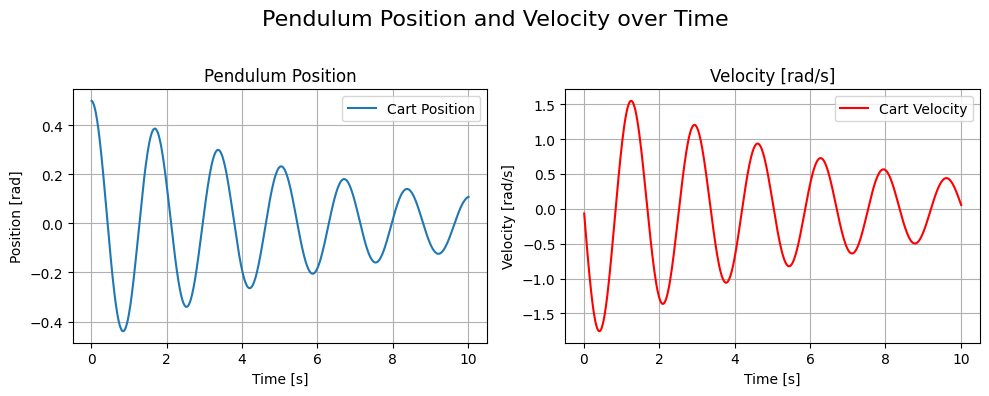

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Pendulum Position and Velocity over Time', fontsize=16)

axs[0].plot(times, positions, label='Cart Position')
axs[0].set_title('Pendulum Position')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Position [rad]')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(times, velocities, 'r', label='Cart Velocity')
axs[1].set_title('Velocity [rad/s]')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Velocity [rad/s]')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [28]:
fig = plt.figure()
plt.axis('off')
img_plot = plt.imshow(frames[0])

def animate(i):
    img_plot.set_data(frames[i])
    return [img_plot]

anim = FuncAnimation(fig, animate, frames=len(frames), interval=1000/framerate, blit=True)
plt.close(fig) # Figure 창이 별도로 뜨는 것을 방지

# HTML5 비디오로 변환하여 Jupyter Notebook에 표시
HTML(anim.to_html5_video())

In [29]:
xml = """
<mujoco model="inverted pendulum">
    <compiler inertiafromgeom="true"/>
    <default>
        <joint armature="0" damping="1" limited="true"/>
        <geom friction="1 0.1 0.1" rgba="0.7 0.7 0 1"/>
        <tendon/>
        <motor ctrlrange="-3 3"/>
    </default>
    <option gravity="0 0 -9.81" integrator="Euler" timestep="0.01"/>
    <size nstack="3000"/>
    <worldbody>
        <geom name="rail" pos="0 0 0" quat="0.707 0 0.707 0" rgba="0.3 0.3 0.7 1" size="0.02 1" 
                type="capsule" contype="0" conaffinity="0"/>
        <body name="cart" pos="0 0 0">
            <joint axis="1 0 0" limited="true" name="slider" pos="0 0 0" range="-1.2 1.2" 
                type="slide"/>
            <geom name="cart" pos="0 0 0" quat="0.707 0 0.707 0" size="0.1 0.1" type="capsule"/>
            <body name="pole" pos="0 0 0">
                <joint axis="0 1 0" name="hinge" pos="0 0 0" type="hinge" limited="false"/>
                <geom fromto="0 0 0 0.001 0 0.6" name="cpole" rgba="0 0.7 0.7 1" size="0.049 0.3" 
                    type="capsule"/>
            </body>
        </body>
    </worldbody>
    <actuator>
        <motor ctrllimited="true" ctrlrange="-3 3" gear="10" joint="slider" name="slide"/>
    </actuator>
</mujoco>
"""

In [30]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height=480, width=640)

In [31]:
duration = 3  # (초)
framerate = 60 # (fps)
frames = []

data.qpos[0] = -0.5

while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

In [32]:
fig = plt.figure()
plt.axis('off')
img_plot = plt.imshow(frames[0])

def animate(i):
    img_plot.set_data(frames[i])
    return [img_plot]

anim = FuncAnimation(fig, animate, frames=len(frames), interval=1000/framerate, blit=True)
plt.close(fig) # Figure 창이 별도로 뜨는 것을 방지

# HTML5 비디오로 변환하여 Jupyter Notebook에 표시
HTML(anim.to_html5_video())

In [33]:
import numpy as np 

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

duration = 10 

times = []
cart_positions = []
cart_velocities = []
pole_angles = []
pole_angular_velocities = []

In [34]:
print("Running simulation...")
while data.time < duration:
    data.ctrl[0] = np.random.uniform(low=-3.0, high=3.0)
    mujoco.mj_step(model, data)
    times.append(data.time)
    
    # Cart의 상태 (slider joint)
    cart_positions.append(data.joint('slider').qpos[0])
    cart_velocities.append(data.joint('slider').qvel[0])
    
    # Pole의 상태 (hinge joint)
    pole_angles.append(data.joint('hinge').qpos[0])
    pole_angular_velocities.append(data.joint('hinge').qvel[0])

print("Simulation finished. ")

Running simulation...
Simulation finished. 


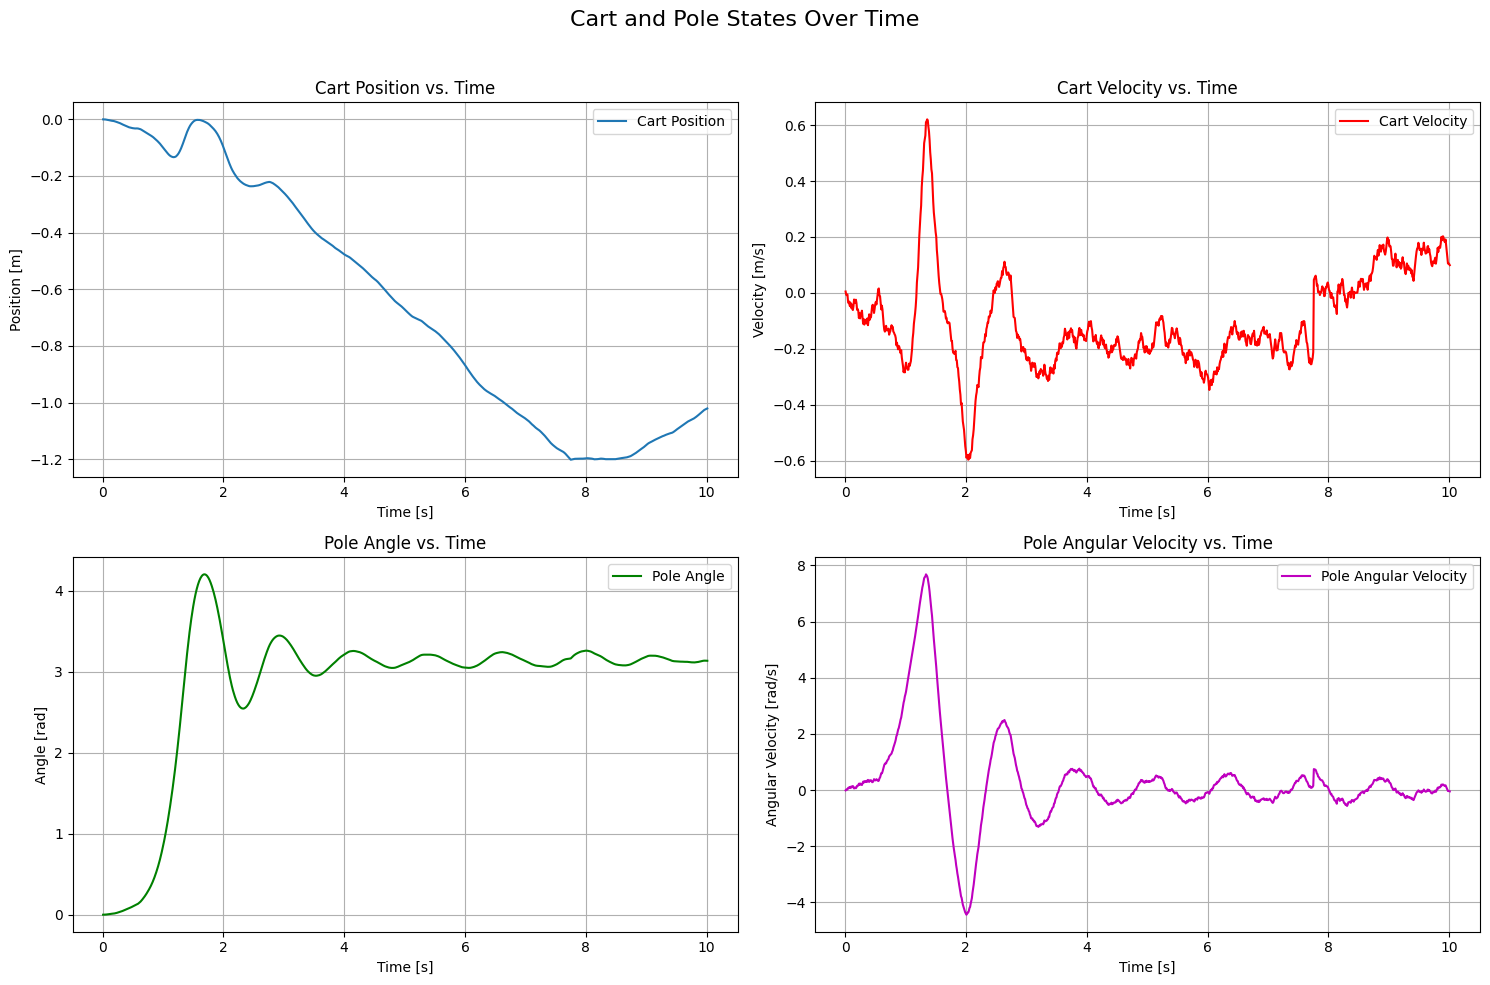

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cart and Pole States Over Time', fontsize=16)

# Cart 위치
axs[0, 0].plot(times, cart_positions, label='Cart Position')
axs[0, 0].set_title('Cart Position vs. Time')
axs[0, 0].set_xlabel('Time [s]')
axs[0, 0].set_ylabel('Position [m]')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Cart 속도
axs[0, 1].plot(times, cart_velocities, 'r', label='Cart Velocity')
axs[0, 1].set_title('Cart Velocity vs. Time')
axs[0, 1].set_xlabel('Time [s]')
axs[0, 1].set_ylabel('Velocity [m/s]')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Pole 각도
axs[1, 0].plot(times, pole_angles, 'g', label='Pole Angle')
axs[1, 0].set_title('Pole Angle vs. Time')
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Angle [rad]')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Pole 각속도
axs[1, 1].plot(times, pole_angular_velocities, 'm', label='Pole Angular Velocity')
axs[1, 1].set_title('Pole Angular Velocity vs. Time')
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('Angular Velocity [rad/s]')
axs[1, 1].grid(True)
axs[1, 1].legend()

# 레이아웃 조정 및 그래프 표시
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [37]:
mujoco.mj_resetData(model, data)
data.qpos[:] = 0
data.qvel[:] = 0

In [41]:
A_d = np.zeros((2*model.nv, 2*model.nv))
B_d = np.zeros((2*model.nv, model.nu))
mujoco.mjd_transitionFD(model, data, 1e-5, True, A_d, B_d, None, None)

In [42]:
A_d

array([[ 1.00000000e+00, -2.84534060e-04,  9.99167743e-03,
         1.92647797e-05],
       [ 0.00000000e+00,  1.00292941e+00,  1.92647797e-05,
         9.80166082e-03],
       [-6.77626358e-16, -2.84534060e-02,  9.99167743e-01,
         1.92647797e-03],
       [ 2.71050543e-15,  2.92940854e-01,  1.92647797e-03,
         9.80166082e-01]])

In [43]:
B_d

array([[ 8.32257410e-05],
       [-1.92647797e-04],
       [ 8.32257410e-03],
       [-1.92647797e-02]])

In [45]:
import control

Q = np.diag([1.0, 10.0, 0.1, 0.1])
R = np.diag([0.1])
K, S, E = control.dlqr(A_d, B_d, Q, R)
K

array([[ -2.98364293, -48.96497592,  -4.71481693,  -7.58670122]])

In [46]:
def design_lqr_controller(model, data):
    mujoco.mj_resetData(model, data)
    data.qpos[:] = 0
    data.qvel[:] = 0
    A_d = np.zeros((2*model.nv, 2*model.nv))
    B_d = np.zeros((2*model.nv, model.nu))
    mujoco.mjd_transitionFD(model, data, 1e-5, True, A_d, B_d, None, None)
    Q = np.diag([1.0, 10.0, 0.1, 0.1])
    R = np.diag([0.1])
    K, S, E = control.dlqr(A_d, B_d, Q, R)
    print("LQR Gain Matrix K:\n", K)
    
    return K

In [47]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model, height=480, width=640)

K = design_lqr_controller(model, data)

duration = 10
framerate = 60

# 초기 상태 설정
data.qpos[0] = 0.0
data.qpos[1] = 0.1

times, frames = [], []
cart_positions, cart_velocities = [], []
pole_angles, pole_angular_velocities = [], []
controls = []

LQR Gain Matrix K:
 [[ -2.98364293 -48.96497592  -4.71481693  -7.58670122]]


In [48]:
print("Running LQR controlled simulation...")
while data.time < duration:
    state = np.array([data.qpos[0], data.qpos[1], data.qvel[0], data.qvel[1]])
    control_input = -K @ state
    data.ctrl[0] = control_input[0]
    mujoco.mj_step(model, data)
    
    times.append(data.time)
    cart_positions.append(data.qpos[0]); pole_angles.append(data.qpos[1])
    cart_velocities.append(data.qvel[0]); pole_angular_velocities.append(data.qvel[1])
    controls.append(control_input[0])

    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

print("Simulation finished.")

Running LQR controlled simulation...
Simulation finished.


In [49]:
print("Creating animation for notebook display...")

fig = plt.figure(figsize=(8, 6))
plt.axis('off')
img_plot = plt.imshow(frames[0])

def animate(i):
    img_plot.set_data(frames[i])
    return [img_plot]

anim = FuncAnimation(fig, animate, frames=len(frames), interval=1000/framerate, blit=True)
plt.close(fig) # Figure 창이 별도로 뜨는 것을 방지

display(HTML(anim.to_html5_video()))

print("Animation display complete.")

Creating animation for notebook display...


Animation display complete.


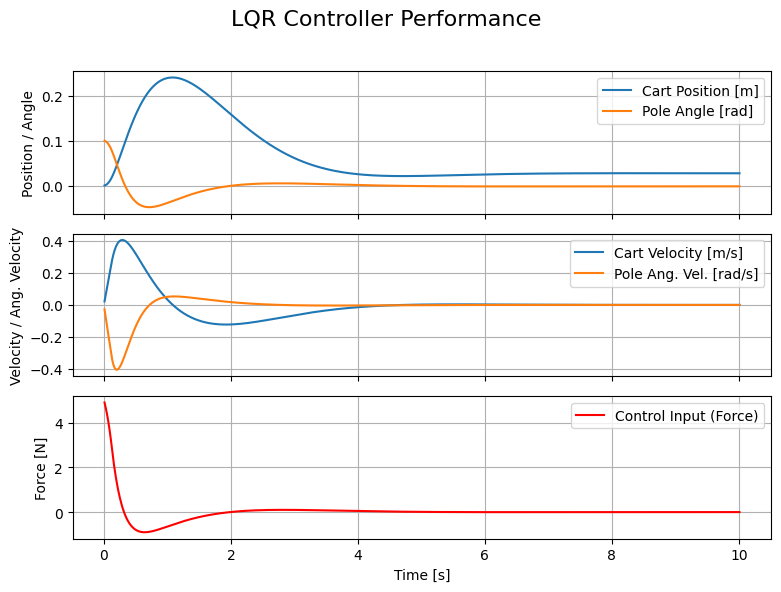

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
fig.suptitle('LQR Controller Performance', fontsize=16)

axs[0].plot(times, cart_positions, label='Cart Position [m]')
axs[0].plot(times, pole_angles, label='Pole Angle [rad]')
axs[0].set_ylabel('Position / Angle'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(times, cart_velocities, label='Cart Velocity [m/s]')
axs[1].plot(times, pole_angular_velocities, label='Pole Ang. Vel. [rad/s]')
axs[1].set_ylabel('Velocity / Ang. Velocity'); axs[1].legend(); axs[1].grid(True)

axs[2].plot(times, controls, 'r', label='Control Input (Force)')
axs[2].set_xlabel('Time [s]'); axs[2].set_ylabel('Force [N]'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [73]:
mujoco.mj_resetData(model, data)

switch_interval = 5.0
target_x = 0.5
next_switch_time = switch_interval

times, frames = [], []
target_positions, cart_positions, cart_velocities = [], [], []
pole_angles, pole_angular_velocities = [], []
controls = []

In [74]:
print("Running LQR setpoint tracking simulation (using 'control' package)...")
while data.time < duration:
    if data.time >= next_switch_time:
        target_x *= -1
        next_switch_time += switch_interval
        print(f"Time: {data.time:.2f}s, New target position: {target_x:.1f}")

    current_state = np.array([data.qpos[0], data.qpos[1], data.qvel[0], data.qvel[1]])
    target_state = np.array([target_x, 0, 0, 0])
    state_error = current_state - target_state
    
    control_input = -K @ state_error
    data.ctrl[0] = control_input[0]
    
    mujoco.mj_step(model, data)
    
    times.append(data.time)
    target_positions.append(target_x)
    cart_positions.append(data.qpos[0]); pole_angles.append(data.qpos[1])
    cart_velocities.append(data.qvel[0]); pole_angular_velocities.append(data.qvel[1])
    controls.append(control_input[0])

    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

print("Simulation finished.")

Running LQR setpoint tracking simulation (using 'control' package)...
Time: 5.01s, New target position: -0.5
Simulation finished.


In [75]:
print("Creating animation for notebook display...")
fig = plt.figure(figsize=(8, 6)); plt.axis('off')
img_plot = plt.imshow(frames[0])

def animate(i):
    img_plot.set_data(frames[i])
    return [img_plot]

anim = FuncAnimation(fig, animate, frames=len(frames), interval=1000/framerate, blit=True)
plt.close(fig) 
display(HTML(anim.to_html5_video()))
print("Animation display complete.")

Creating animation for notebook display...


Animation display complete.


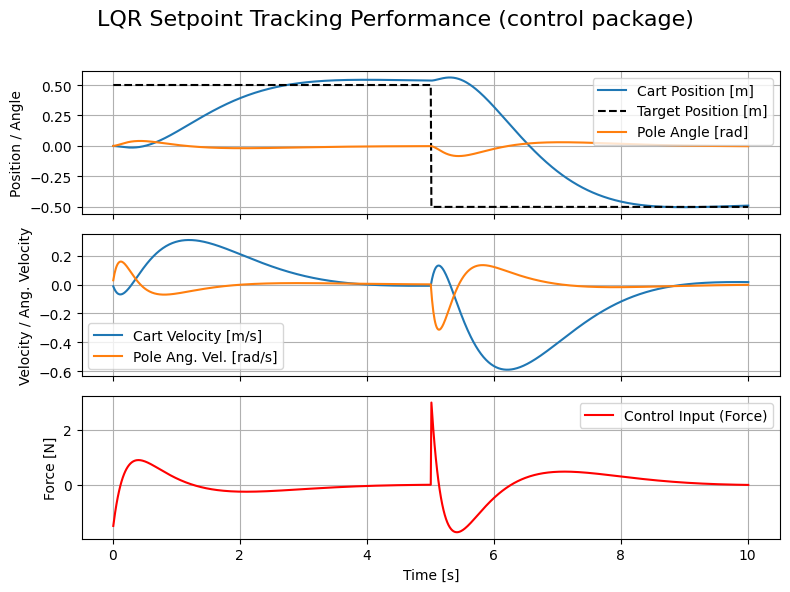

In [78]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
fig.suptitle('LQR Setpoint Tracking Performance (control package)', fontsize=16)
axs[0].plot(times, cart_positions, label='Cart Position [m]')
axs[0].plot(times, target_positions, 'k--', label='Target Position [m]')
axs[0].plot(times, pole_angles, label='Pole Angle [rad]')
axs[0].set_ylabel('Position / Angle'); axs[0].legend(); axs[0].grid(True)
axs[1].plot(times, cart_velocities, label='Cart Velocity [m/s]')
axs[1].plot(times, pole_angular_velocities, label='Pole Ang. Vel. [rad/s]')
axs[1].set_ylabel('Velocity / Ang. Velocity'); axs[1].legend(); axs[1].grid(True)
axs[2].plot(times, controls, 'r', label='Control Input (Force)')
axs[2].set_xlabel('Time [s]'); axs[2].set_ylabel('Force [N]'); axs[2].legend(); axs[2].grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()